In [1]:
from exod.pre_processing.data_loader import DataLoader
from exod.pre_processing.event_filtering import filter_obsid_events, create_obsid_images
from exod.processing.variability import plot_var_with_regions, get_region_lightcurves, plot_region_lightcurves
from exod.utils.logger import logger, get_current_date_string
from exod.utils.path import save_df
from exod.xmm.observation import Observation
from exod.processing.detector import Detector

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from exod.utils.path import data_processed, data_results
from exod.utils.logger import logger

import numpy as np
from astropy.convolution import convolve
from astropy.stats import sigma_clip
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
import pandas as pd
from matplotlib.colors import LogNorm
from scipy.stats import kstest, poisson
from skimage.measure import label, regionprops, regionprops_table

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
from photutils.detection import daofinder, irafstarfinder, starfinder

from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

from astropy.stats import sigma_clipped_stats

2024-02-08 17:17:28,763 - INFO - event_list.py:remove_bad_rows - Removing Bad PN Rows Struder et al. 2001b
2024-02-08 17:17:28,863 - INFO - event_list.py:remove_borders - Removing Borders: EPN PrimeFullWindow
2024-02-08 17:17:29,266 - INFO - data_loader.py:get_high_energy_lc - min_energy_he = 10.0 max_energy_he = 12.0 gti_window_size = 100
2024-02-08 17:17:29,282 - INFO - bti.py:get_bti - Curve Started and Ended above threshold!
2024-02-08 17:17:29,319 - INFO - bti.py:plot_bti - saving bti plot to: /home/nkhan/EXOD2/data/results/0803990501/bti_plot.png
2024-02-08 17:17:29,479 - INFO - event_list.py:filter_by_energy - Filtering Events list by energy min_energy=0.2 max_energy=12.0
2024-02-08 17:17:29,537 - INFO - data_loader.py:create_data_cube - Creating Data Cube...
2024-02-08 17:17:31,536 - INFO - data_cube.py:crop_data_cube - Cropping data cube between bbox_img: (38, 240, 36, 244)
2024-02-08 17:17:31,537 - INFO - data_loader.py:drop_bti_from_data_cube - gti_only=True, dropping bad fr

TypeError: Detector.__init__() got an unexpected keyword argument 'wcs'

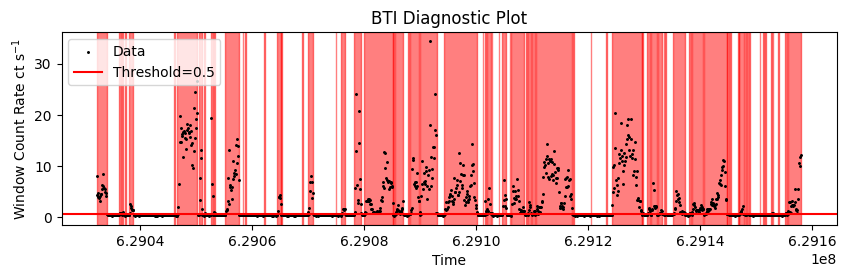

In [6]:
obsid         = '0803990501' # '0670170501'
size_arcsec   = 10.0
time_interval = 50
gti_only      = True
gti_threshold = 0.5
min_energy    = 0.2
max_energy    = 12.0
sigma         = 5
clobber       = False


# Create the Observation class
observation = Observation(obsid)
observation.get_files()

# Get the eventslist & image to use
event_list = observation.events_processed_pn[0]
event_list.read()

img = observation.images[0]
img.read(wcs_only=True)

# Initialize the Data Loader
dl = DataLoader(event_list=event_list,
                size_arcsec=size_arcsec,
                time_interval=time_interval,
                gti_only=gti_only,
                gti_threshold=gti_threshold,
                min_energy=min_energy,
                max_energy=max_energy)
dl.run()

# Create Data Cube
#data_cube.plot_cube_statistics()
# data_cube.video()

# Create and run detector
detector = Detector(data_cube=dl.data_cube, wcs=img.wcs)
detector.run()

# Create Lightcurve dataframe
df_lcs = get_region_lightcurves(dl.data_cube, detector.df_regions)

# Plot Variable Regions
plot_outfile = observation.path_results / 'var_img.png'
plot_var_with_regions(var_img=detector.var_img, df_regions=detector.df_regions, savepath=plot_outfile)

# Plot Lightcurves files
if len(detector.df_regions) < 15:
    plot_region_lightcurves(df_lcs=df_lcs, df_regions=detector.df_regions, obsid=obsid)

# Save Results
save_df(df=dl.df_bti,  savepath=observation.path_results / 'bti.csv')
save_df(df=df_lcs,              savepath=observation.path_results / 'lcs.csv')
save_df(df=detector.df_regions, savepath=observation.path_results / 'regions.csv')
obs_info = observation.info
evt_info = event_list.info
dl_info = dl.info
dc_info = dl.data_cube.info
det_info = detector.info
plt.show()

In [7]:
class Source:
    def __init__(self, id, X, Y):
        self.id = id
        self.X = X
        self.Y = Y
        
    def __repr__(self):
        return f'Source(id={self.id} X={self.X:.3f}, Y={self.Y:.3f})'

    @classmethod
    def from_dao(cls, row):
        """Create Source from row in daofinder.DAOStarFinder result table."""
        s = cls(row['id'], row['xcentroid'], row['ycentroid'])
        s.sharpness  = row['sharpness']
        s.roundness1 = row['roundness1']
        s.roundness2 = row['roundness2']
        s.npix       = row['npix']
        s.sky        = row['sky']
        s.peak       = row['peak']
        s.flux       = row['flux']
        s.mag        = row['mag']
        return s

    @classmethod
    def from_peaks(cls, row):
        """Create Source from row in daofinder.DAOStarFinder result table."""
        pass
        
    @property
    def info(self):
        info = {'id' : self.id,
                'X'  : self.X,
                'Y'  : self.Y}
        return info

class SourceCollection:
    def __init__(self):
        self.sources = []

    def add_source(self, source):
        self.sources.append(source)
        
    def to_df():
        return pd.DataFrame([s.info for s in self.sources])

    def to_table():
        tab = []
        return tab


class Detector:
    def __init__(self, data_cube):
        self.data_cube = data_cube
        self.image_max = np.nanmax(self.data_cube.data, axis=2)
        self.image_std = np.nanstd(self.data_cube.data, axis=2)
        self.image_sum = np.nansum(self.data_cube.data, axis=2)
        self.image_var = self.image_max * self.image_std

        # Masking Bright Sources
        self.image_mask = None
        self.mask_percentile = None
        self.mask_percentile_val = None

        # Sigma Clipping For Background Estimation
        self.sigma_clip = 3.0          # Sigmas for background Estimation
        self.var_sigma_threshold = 6.0 # Sigmas for source Extraction
        self.var_mean_sc, self.var_median_sc, self.var_std_sc = self.calc_sigma_clipped_stats()

        # Detection Thresholds for DAO star finder
        self.threshold_dao = self.calc_detection_threshold()
        self.fwhm_dao      = 1.5

        # Detected Sources
        self.sources = []
    
    def __repr__(self):
        return f'Detector({data_cube})'

    def mask_bright_sources(self, percentile=99.97):
        """Mask Bright Sources by sum image."""
        self.mask_percentile = percentile
        self.mask_percentile_val = np.percentile(self.image_sum, self.mask_percentile)
        self.image_mask  = self.image_sum > self.mask_percentile

    def calc_sigma_clipped_stats(self):
        """Calculate the sigma clipped statistics for the variability image."""
        mean, median, std = sigma_clipped_stats(self.image_var, sigma=self.sigma_clip)
        logger.info(f'mean={mean:.2f} median={median:.2f} std={std:.2f}')
        return mean, median, std
        
    def calc_detection_threshold(self):
        """Calculate the Detection threshold."""
        threshold = self.var_mean_sc + (self.var_sigma_threshold * self.var_std_sc)
        logger.info(f'threshold={threshold:.2f}')
        return threshold
    
    def detect_dao(self, fwhm=1.0, **kwargs):
        """Detect Sources in variability image using DAO starfinder."""
        sf = daofinder.DAOStarFinder(threshold=self.threshold_dao, fwhm=fwhm, exclude_border=True,)
        self.tab_dao = sf.find_stars(self.image_var, mask=self.image_mask, **kwargs)
        if self.tab_dao:
            self.sources = [Source.from_dao(r) for r in self.tab_dao]
        else:
            logger.info('No Sources Found!')

    def plot_image_mask(self):
        plt.figure(figsize=(6,6))
        plt.title(f'Image mask | percentile={self.mask_percentile} | value={self.mask_percentile_val:.2f}')
        plt.imshow(self.image_mask, interpolation='none', cmap='grey')
        plt.show()
        
    def plot_image_var(self, savepath=None):
        logger.info('Plotting Variability map with source regions')
    
        # Colors and Normalisation
        cmap = plt.cm.hot
        cmap.set_bad('black')
        norm = ImageNormalize(stretch=SqrtStretch()) #LogNorm()
    
        # Plot Image
        fig, ax = plt.subplots(figsize=(10,10))
        m1 = ax.imshow(self.image_var, norm=norm, interpolation='none', origin='lower', cmap=cmap)
        cbar = plt.colorbar(mappable=m1, ax=ax, shrink=0.75)
        cbar.set_label("Variability")

        # Plot Sources
        source_color = 'lime'
        Xs = [s.X for s in self.sources]
        Ys = [s.Y for s in self.sources]

        apertures = CircularAperture(np.transpose((Xs, Ys)), r=3.0)
        
        plt.scatter(Xs, Ys, marker='.', s=10, color=source_color)
        apertures.plot(color=source_color, lw=1.0, alpha=0.5, ax=ax)
        
        for s in self.sources:
            offset = 2
            plt.text(s.X+offset, s.Y+offset, str(s.id), c=source_color)
        plt.tight_layout()
        
        if savepath:
            logger.info(f'Saving Variability image to: {savepath}')
            plt.savefig(savepath)

    def plot_3d_image(self, image):
        xx, yy = np.mgrid[0:image.shape[0], 0:image.shape[1]]
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(projection='3d')
        ax.plot_surface(xx, yy, image , rstride=1, cstride=1, cmap='plasma', linewidth=0) # , antialiased=False
        
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_zticks([])
        
        plt.show()
    
    
    def detect_skimage(self):
        """Detect Sources in variability image using skimage label."""
        pass

    def sources_to_df(self):
        return pd.DataFrame([s.info for s in self.sources])

    @property
    def n_sources(self):
        return len(self.sources)
        
    @property
    def info(self):
        info = {'data_cube'             : self.data_cube,
                'n_sources'             : self.n_sources,
                'mask_percentile'       : self.mask_percentile,
                'mask_percentile_val'   : self.mask_percentile_val,
                'threshold_dao'         : self.threshold_dao,
                'fwhm_dao'              : self.fwhm_dao}
        for k, v in info.items():
            logger.info(f'{k:>21} : {v}')
        return info
    


2024-02-08 17:18:49,277 - INFO - 3369951264.py:calc_sigma_clipped_stats - mean=0.12 median=0.11 std=0.13
2024-02-08 17:18:49,278 - INFO - 3369951264.py:calc_detection_threshold - threshold=0.91


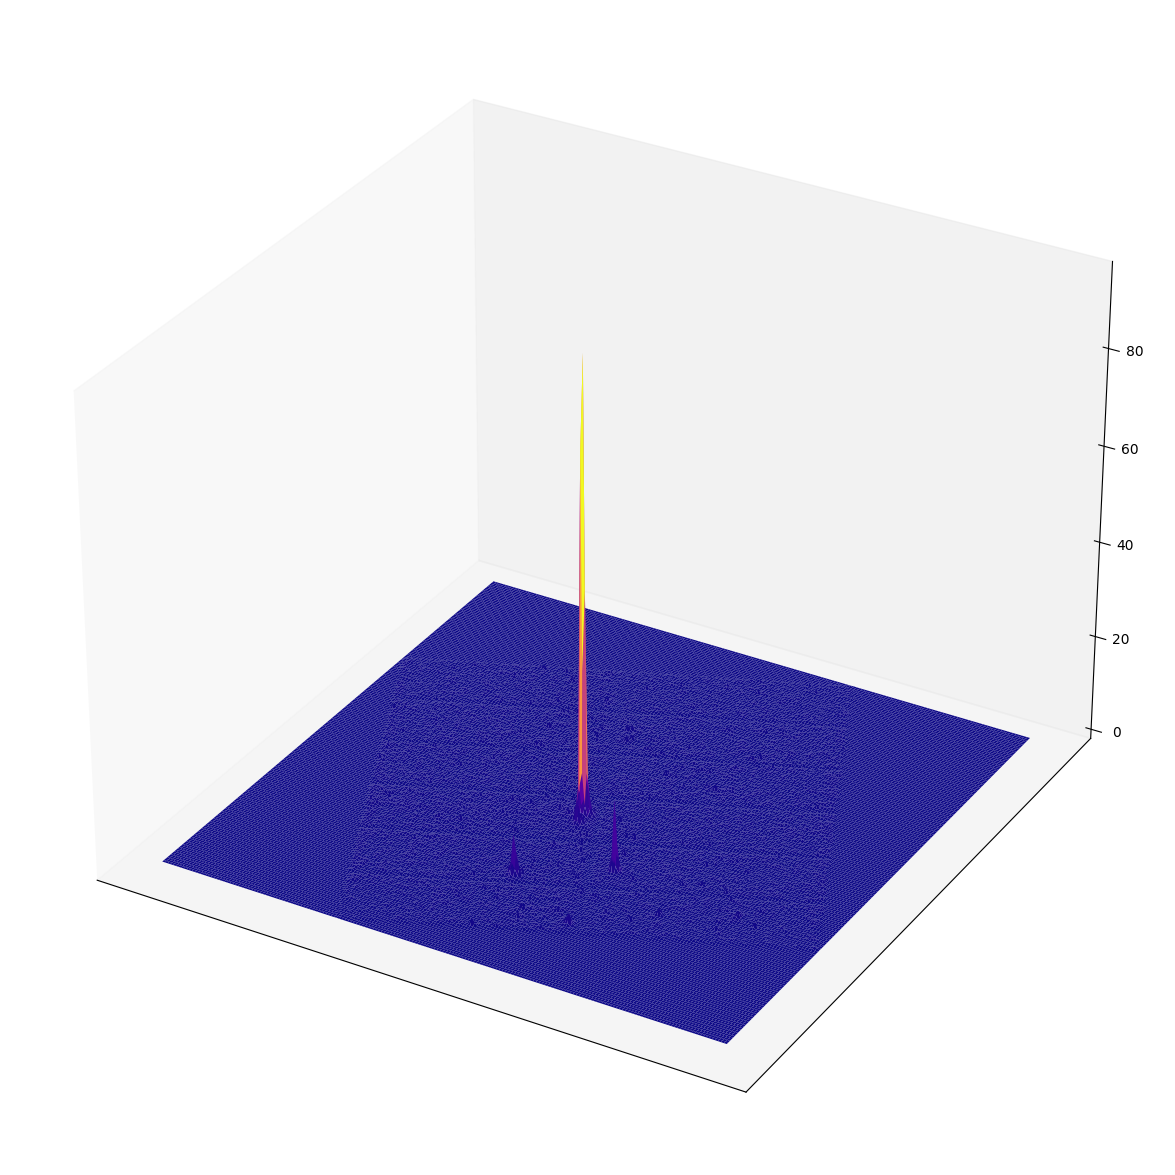

In [10]:
detector = Detector(data_cube=dl.data_cube)
detector.plot_3d_image(detector.image_var)

2024-02-08 17:18:57,947 - INFO - 3369951264.py:calc_sigma_clipped_stats - mean=0.12 median=0.11 std=0.13
2024-02-08 17:18:57,948 - INFO - 3369951264.py:calc_detection_threshold - threshold=0.91
2024-02-08 17:18:57,973 - INFO - 3369951264.py:plot_image_var - Plotting Variability map with source regions


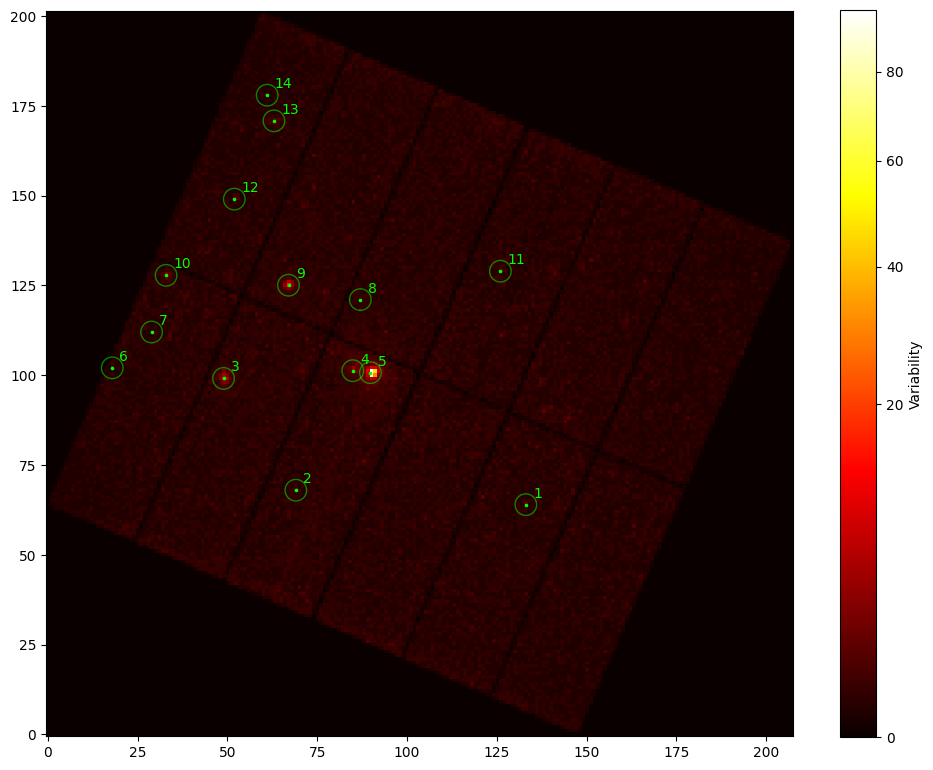

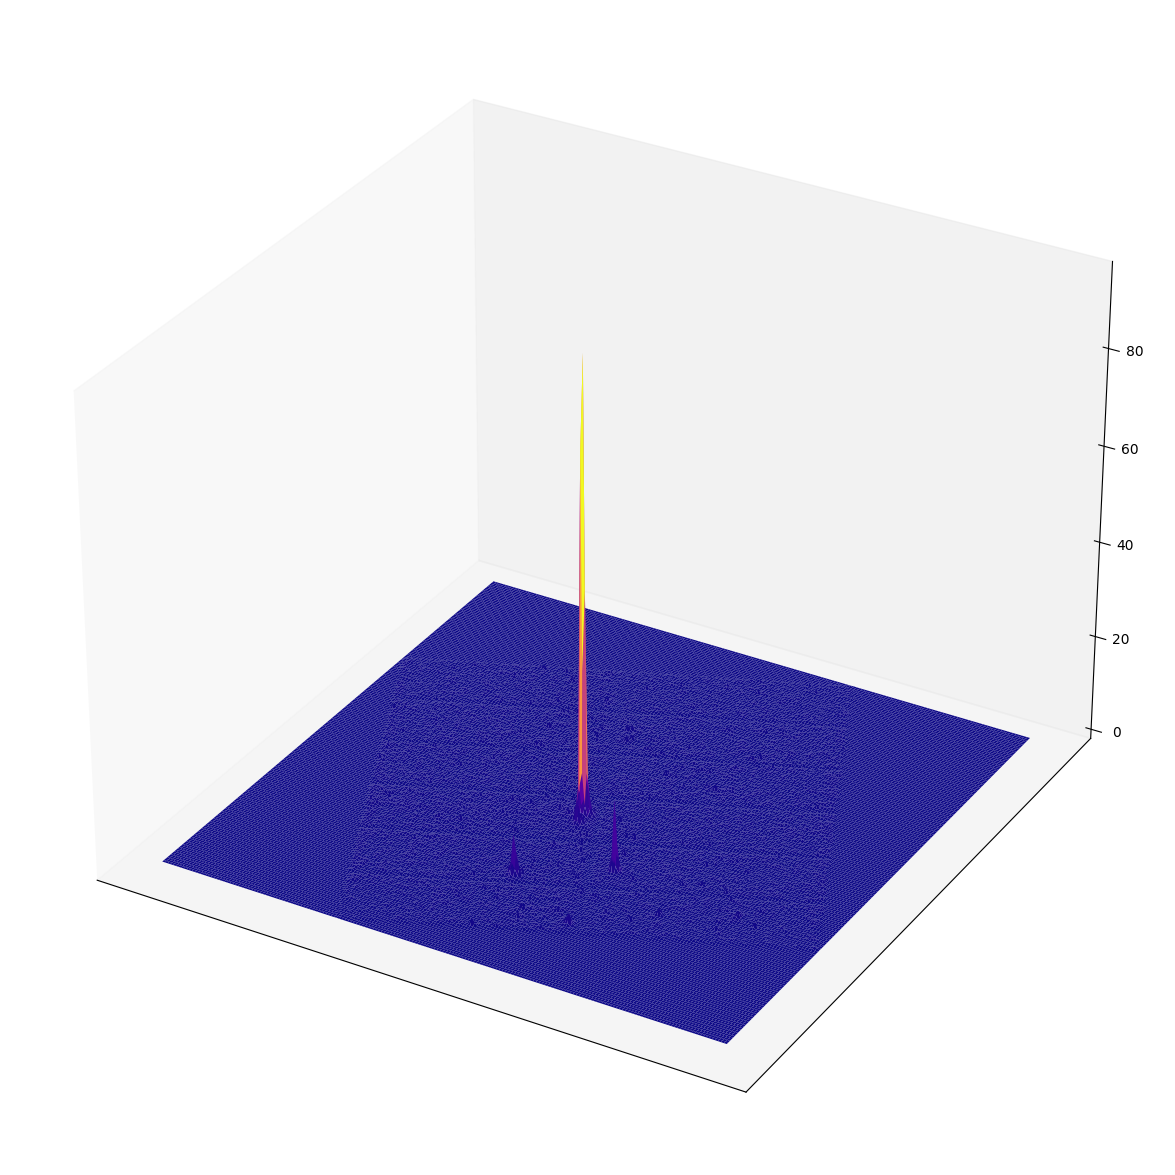

2024-02-08 17:18:59,955 - INFO - 3369951264.py:info -             data_cube : DataCube(shape=(202, 208, 2518), total_values=105796288, memory=807.16 MB)
2024-02-08 17:18:59,956 - INFO - 3369951264.py:info -             n_sources : 14
2024-02-08 17:18:59,956 - INFO - 3369951264.py:info -       mask_percentile : None
2024-02-08 17:18:59,957 - INFO - 3369951264.py:info -   mask_percentile_val : None
2024-02-08 17:18:59,957 - INFO - 3369951264.py:info -         threshold_dao : 0.9112118700781595
2024-02-08 17:18:59,957 - INFO - 3369951264.py:info -              fwhm_dao : 1.5


    id           X           Y
0    1  133.062951   63.987736
1    2   69.033434   68.009859
2    3   48.902569   99.126709
3    4   84.879430  101.280381
4    5   89.801662  100.730136
5    6   17.917618  102.067326
6    7   28.871399  112.048056
7    8   86.982198  121.072607
8    9   66.987138  125.079280
9   10   32.911051  127.834764
10  11  125.986403  128.979041
11  12   51.894432  149.048274
12  13   62.938811  170.840985
13  14   61.060015  177.976348


In [11]:
detector = Detector(data_cube=dl.data_cube)
#detector.mask_bright_sources(percentile=99.99997)
#detector.plot_image_mask()
detector.detect_dao(fwhm=0.5)
detector.plot_image_var()
detector.plot_3d_image(detector.image_var)

df = detector.sources_to_df()
print(df)
det_info = detector.info

In [ ]:
a   = detector.image_sum
arr = sigma_clip(a, sigma=50, maxiters=5, masked=True)
plt.imshow(arr)




#a = a[a>0]
#a_log = np.log10(a)
#v = np.percentile(a_log, 99.97)
#val = 10**v
#print(val)
#plt.figure(figsize=(4,3))
#plt.axvline(v, color='red')
#plt.hist(a_log, bins=100)
#plt.xlabel('log10(sum image)')
#plt.ylabel('Count')
#plt.show()

In [14]:
detector.

SyntaxError: invalid syntax (3678383469.py, line 1)

In [ ]:
from photutils.detection import find_peaks

In [ ]:
tab_peaks

In [ ]:
img_mask.shape

In [ ]:
img_sum   = np.nansum(data_cube.data, axis=2)
img_mask  = img_sum > np.percentile(img_sum, 99.97)
tab_peaks = find_peaks(var_img, threshold=1.0, box_size=3, mask=img_mask)
tab_peaks

fig, ax = plt.subplots(figsize=(10,10))
imshow = ax.imshow(var_img, cmap='hot', origin='lower', norm=norm, interpolation='none')
plt.scatter(tab_peaks['x_peak'], tab_peaks['y_peak'], color='lime', marker='.', s=10)
plt.tight_layout()
plt.show()

In [ ]:
from astropy.stats import sigma_clipped_stats


mean, median, stddev = sigma_clipped_stats(var_img)
mean, median, stddev

In [ ]:
sources